# Classification 

## Libraries selection
Here I used python programming language and several libraries of python. 
1.	Data preparation part: Keras, Pandas, Numpy, Scikit-learn, PIL, OS
2.	Model building: Keras, Tensorflow
3.	Performance evaluation: Keras, Tensorflow, Scikit-learn
4.	Data visualization: Matplotlib 

I divide this project into four stages:
1.	Data Preparation
2.	Model Building 
3.	Train and Validate model
4.	Performance Evaluation

## Details Description of Each Stage
### Data Preparation
The main dataset contains a total of 112 images from 3 skin disease classes. These three classes are:
1.	Acne: 40 images
2.	Herpes Simplex: 16 images
3.	Lichen Planus: 56 images

At first, divide the dataset into two parts: Train+Validation and Test. Here, the Train+Validation set contains 88 images (Acne: 32 images, Herpes Simplex: 12 images, Lichen Planus: 44 images), and the test set contains 24 images (Acne: 8 images, Herpes Simplex: 4 images, Lichen Planus: 12 images). In addition, 
we can see two problems from the Train+Validation dataset. On the one hand, it has a small number of data to train the model, and on the other hand, it is a class imbalance dataset (Herpes Simplex has only 12 images). Therefore, I take two approaches to solve these two issues. Firstly, I use the Offline Data Augmentation procedure to increase the data. Secondly, I enhanced the number of Herpes Simplex images by utilizing Oversampling technique with data augmentation to tackle the data imbalance issue. I produced 958 images for train and validation by these two procedures altogether. Here, 320  images are Acne images ( 10 images produced from each one), 264 image files from Herpes Simplex (22 images produced from each one), and 374 files from the Lichen Planus class (almost 9 images produced from each one). I utilize rotation, width shift, height shift, shear, zoom, horizontal flip methods for offline data augmentation. 

After that, I used a stratified train-test split to split the training and validation dataset where the training set is comprised of 862 images and the validation set contains 96 images. 
At last, I resize the train, validation, and test set to 224X224, then normalize the dataset, and at last convert it to a NumPy array. In this way, I reduce the dimensionality and training time, making the model more proficient for practical life. 


### Model Building
To train the dataset, I used RAM-Net architecture which is built on Tensorflow and Keras. I developed this Residual Attention Mobilenet (RAM-Net) in the last year for medical image analysis, and this is a published work at ICMLA 2020 conference. This is a mobile-friendly computer vision network with fewer parameters and flops with the capabilities to achieve higher performance on image datasets. So, I decide to choose this model as I am confident enough about its performance. 

### Train and Validate model
I use ImageNet pre-trained weight to train the model to achieve high accuracy.  

Hyperparameters and Online Data Augmentations:
1.	Loss function: categorical cross-entropy
2.	Optimizer: Adam
3.	 I also use online data augmentation for the training. Online data augmentation function: rotation, width shift, height shift, shear, zoom, and fill mode=nearest
4.	epoch= 40 
5. batch size=32 

Callback Functionality:
1.	ReduceLROnPlateau: for the learning rate reduction, if I do not get acceptable accuracy after each 5 epochs in my validation set
2.	ModelCheckpoint: to save the best model after each epoch

### Performance Evaluation
I use the test set for the performance evaluation. I did not apply any augmentation in these test images, and these are basic images provided by ORO Health. 
For the performance evaluation, I use several performance evaluation matrices:
1.	Test accuracy
2.	confusion matrix
3.	Precision
4.	Recall
5.	F1 Score



## Import Libraries

In [37]:
#import libraries
import os
from glob import glob
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from sklearn.metrics import classification_report
import functools
import keras
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import matplotlib.cm as cm
import numpy
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import MobileNet
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
import random
from keras.layers import Dense, Dropout, GlobalAveragePooling2D,GlobalMaxPooling2D,DepthwiseConv2D,Concatenate
import matplotlib.pyplot as plt
import tensorflow
from at import augmented_conv2d
from sklearn.metrics import confusion_matrix
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

## Load train and validation set

In [38]:
X_train = np.load("skin_224_224_train.npy")
y_train = np.load("skin_train_labels.npy")
X_val = np.load("skin_224_224_val.npy")

y_val = np.load("skin_val_labels.npy")

print('train set: ', X_train.shape, y_train.shape )
print('validation set: ',X_val.shape, y_val.shape)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)
print(y_val.shape)
#print(y_val)

train set:  (862, 224, 224, 3) (862,)
validation set:  (96, 224, 224, 3) (96,)
(862, 3)
(96, 3)


## Display 2 Training and 2 Validation Examples 

2 training examples: 


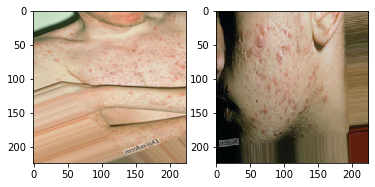

2 validation examples: 


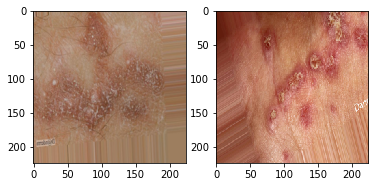

In [39]:
#display three examples
def display(x,y):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    # Bilinear interpolation - this will look blurry
    ax1.imshow(x, interpolation='bilinear', cmap=cm.Greys_r)

    ax2 = fig.add_subplot(122)
    # 'nearest' interpolation - faithful but blocky
    ax2.imshow(y, interpolation='nearest', cmap=cm.Greys_r)

    plt.show()
print("2 training examples: ")
display(X_train[100],X_train[200])

print("2 validation examples: ")
display(X_val[10],X_val[40])
#display(images[250],mask[250])

## Use ImageNet Pre-trained Weights 

In [40]:
f=augmented_conv2d #attention augmented convolution
print(f,type(f))

#take pretrained weight of imagenet for thr last few classifier layers
pre_trained_model = MobileNet(input_shape=(224,224, 3), include_top=False, weights="imagenet")

<function augmented_conv2d at 0x000002724AAE4C80> <class 'function'>


In [41]:
for layer in pre_trained_model.layers:
    #print(layer.name)
    layer.trainable = False

In [42]:
#print(len(pre_trained_model.layers))
last_layer = pre_trained_model.get_layer('conv_pw_13_relu')
#print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
x=GlobalAveragePooling2D()(last_output)
#x=Dense(512,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x = Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)


#x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.7
#x = layers.Dropout(0.5)(x)


# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax',name='visualized_layer')(x)

model=Model(pre_trained_model.input, x)


In [43]:
optimizer =Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','top_k_categorical_accuracy'])

model.summary()


train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

batch_size = 32
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

Epoch 1/3
26/26 [==============================] - 9s 328ms/step - loss: 1.2859 - accuracy: 0.4566 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7985 - val_accuracy: 0.6250 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/3
26/26 [==============================] - 8s 313ms/step - loss: 0.8462 - accuracy: 0.6108 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7141 - val_accuracy: 0.7708 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/3
26/26 [==============================] - 7s 285ms/step - loss: 0.6348 - accuracy: 0.7349 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5244 - val_accuracy: 0.7292 - val_top_k_categorical_accuracy: 1.0000


In [44]:
def identity_block(X, f, filters):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    #conv_name_base = 'res' + str(stage) + block + '_branch'
    #bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X
    #print(X_shortcut)

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    #extra
    
     # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)



    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    #conv_name_base = 'res' + str(stage) + block + '_branch'
    #bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X
    
    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s),  kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)



    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


'''for layer in model.layers[:20]:
    layer.trainable = False

for layer in model.layers[20:]:
    layer.trainable = True'''
for layer in model.layers[:12]:
    layer.trainable=True
for layer in model.layers[12:13]:
    layer.trainable=DepthwiseConv2D(64,strides=(2, 2),dilation_rate=(1,1))
for layer in model.layers[13:25]:
    layer.trainable=True
for layer in model.layers[25:26]:
    layer.trainable=DepthwiseConv2D(128,strides=(2, 2),dilation_rate=(1,1))
for layer in model.layers[26:38]:
    layer.trainable=True
for layer in model.layers[38:39]:
    layer.trainable=DepthwiseConv2D(256,strides=(2, 2),dilation_rate=(2,2))

for layer in model.layers[39:75]:
    layer.trainable=True
    #layer.trainable=identity_block(layer.output,3,[64, 64, 256], stage=1, block='a')
for layer in model.layers[75:76]:
    layer.trainable=DepthwiseConv2D(512,strides=(2, 2),dilation_rate=(2,2))
'''
for layer in model.layers[76:81]:
    layer.trainable=identity_block(layer.output,3,[128, 128, 512], stage=2, block='a')
    #layer.trainable=True'''
for layer in model.layers[76:78]:
    ca1=convolutional_block(layer.output, f = 3, filters = [64, 64, 256],s=1)
    a1=identity_block(ca1, 3, [64, 64, 256])
    b1=identity_block(a1,3,[64, 64, 256])
    #ba1=BatchNormalization()(b1)
    ac1= augmented_conv2d(b1, 512)
    ca2 = convolutional_block(ac1, f=3, filters=[128, 128, 512], s=1)
    a2 = identity_block(ca2, 3, [128, 128, 512])
    b2 = identity_block(a2, 3, [128, 128, 512])
    c2 = identity_block(b2, 3, [128, 128, 512])
    #ba2=BatchNormalization()(c2)
    ac2=augmented_conv2d(c2,512)
    
    ca3= convolutional_block(ac2, f=3, filters=[256, 256, 1024], s=1)
    a3 = identity_block(ca3, 3, [1256, 256, 1024])
    b3 = identity_block(a3, 3, [256, 256, 1024])
    c3 = identity_block(b3, 3, [256, 256, 1024])
    
    #layer.trainable=Concatenate([ca,a,b])

    layer.trainable=c3
    #print('man')
    layer.trainable=True
for layer in model.layers[78:81]:
    layer.trainable=True
for layer in model.layers[81:82]:

    #res2=identity_block(res1,3,[128, 128, 512], stage=3, block='b')
    #res3=identity_block(res2,3,[128, 128, 512], stage=3, block='c')

    a=DepthwiseConv2D(1024, strides=(2, 2),dilation_rate=(4,4))
    b=DepthwiseConv2D(1024, strides=(2, 2),dilation_rate=(8,8))
    c=DepthwiseConv2D(1024, strides=(2, 2),dilation_rate=(16,16))
    d=Concatenate([a,b])
    layer.trainable=Concatenate([d,c])
for layer in model.layers[82:]:
    layer.trainable=True





## Train and Validate model

Total Trainable parameters in RAM-Net: 3,863,875

Loss function: Binary cross-entropy

Optimizer: Adam

In addition, I also use online data augmentation for the training.

Online data augmentation function: rotation, width shift, height shift, shear, zoom, and fill mode=nearest

epoch= 40 

batch size=32

Callback Functions: ReduceLROnPlateau, ModelCheckpoint


In [45]:
model._get_distribution_strategy = lambda: None
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc','top_k_categorical_accuracy'])

#save_best = ModelCheckpoint(filepath='D:/polynomial/covid19/inception_dl4_val_new/checkpoint-{val_acc:.4f}.h5',monitor='val_acc',mode='auto',save_best_only=True)
save_best=ModelCheckpoint('RAM_Net.h5', verbose=1,monitor='val_acc',save_best_only=True, save_weights_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=np.sqrt(0.1),
                                            min_lr=0.5e-6, cooldown=0,mode='auto')
callbacks=[learning_rate_reduction,save_best]

model.summary()

batch_size = 32
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=callbacks)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

Epoch 1/30
26/26 [==============================] - 11s 439ms/step - loss: 0.4058 - acc: 0.8422 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3198 - val_acc: 0.5521 - val_top_k_categorical_accuracy: 1.0000

Epoch 00001: val_acc improved from -inf to 0.55208, saving model to RAM_Net.h5
Epoch 2/30
26/26 [==============================] - 9s 327ms/step - loss: 0.2603 - acc: 0.9205 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.8628 - val_acc: 0.3542 - val_top_k_categorical_accuracy: 1.0000

Epoch 00002: val_acc did not improve from 0.55208
Epoch 3/30
26/26 [==============================] - 8s 298ms/step - loss: 0.2455 - acc: 0.9277 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.8820 - val_acc: 0.5833 - val_top_k_categorical_accuracy: 1.0000

Epoch 00003: val_acc improved from 0.55208 to 0.58333, saving model to RAM_Net.h5
Epoch 4/30
26/26 [==============================] - 8s 289ms/step - loss: 0.2229 - acc: 0.9349 - top_k_categorical_accuracy: 1.0000 - val_loss: 5.2078 - va

## Performance evaluation

For the performance evaluation, I use several performance evaluation matrices:

1. Test accuracy
2. confusion matrix
3. Precision
4. Recall
5. F1 Score

96/96 [==============================] - 0s 4ms/step
Validation accuracy= 1.000000  ;  loss_v= 0.000516
2 test examples: 


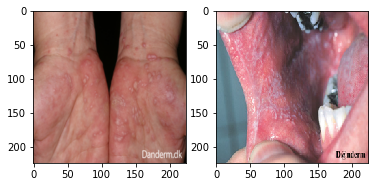

True Label for the test set:  [2 0 2 0 2 0 2 2 2 1 2 2 2 1 0 2 2 0 0 0 2 0 1 1]
Predicted label for the test set: [2 0 2 0 2 0 2 2 2 1 1 2 2 2 0 2 2 0 0 0 2 0 1 1]
                precision    recall  f1-score   support

          acne       1.00      1.00      1.00         8
herpes_simplex       0.75      0.75      0.75         4
 lichen_planus       0.92      0.92      0.92        12

      accuracy                           0.92        24
     macro avg       0.89      0.89      0.89        24
  weighted avg       0.92      0.92      0.92        24

24/24 [==============================] - 0s 2ms/step
Test: accuracy = 0.916667  ;  loss = 1.529458
24/24 [==============================] - 0s 2ms/step
confusion matrix [[ 8  0  0]
 [ 0  3  1]
 [ 0  1 11]]


In [46]:
model.load_weights('RAM_Net.h5')
loss_val, acc_val,top5 = model.evaluate(X_val, y_val, verbose=1)
print("Validation accuracy= %f  ;  loss_v= %f" % (acc_val, loss_val))
#print('top5 validate accuracy: ',top5)
#print('top3 validate accuracy: ',top3)


X_test = np.load("test.npy")
y_test = np.load("test_labels.npy")

print("2 test examples: ")
display(X_test[7],X_test[12])
#print("1st ytest: ",y_test)
print("True Label for the test set: ",y_test)
target_names = ['acne', 'herpes_simplex','lichen_planus']
#print("1st y_test",y_test, y_test.shape)
y_pred = model.predict(X_test)
#print("Test Accuracy",y_pred.astype(float),y_pred.shape,type(y_pred))
np.set_printoptions(precision=3, suppress=True)
#print("1: ",y_pred)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
#print("2: ",y_pred)

y_classes = y_pred.argmax(axis=-1)
print("Predicted label for the test set:",y_classes)

#print("5th y_pred",y_classes,y_classes.shape)
print(classification_report(y_test, y_classes, target_names=target_names))
y_test = to_categorical(y_test)
#print("2nd y_test",y_test)

#print("2nd ytest: ",y_test)

loss_test, acc_test,top5 = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
#print("top5 test accuracy: ",top5)
#print("top3 test accuracy: ",top3)


pre=model.predict(X_test,verbose=1)
#print("pre",pre)
n_values=3
c = np.eye(n_values, dtype=int)[np.argmax(pre, axis=1)]
#print('one-hot-encoding',c)
cm = confusion_matrix(y_test.argmax(axis=1), c.argmax(axis=1))
print("confusion matrix",cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print('new_cm',cm)
#print('acc',cm.diagonal())

### To sum up, all the evaluation functions prove that My algorithm (RAM-Net) perfectly detects the Acne, Herpes complex, and Lichen planus images with high confidence. In addition, the test accruacy is 92%.